# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

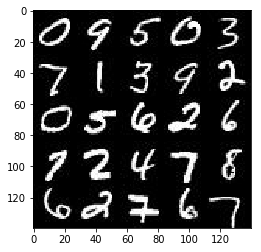

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

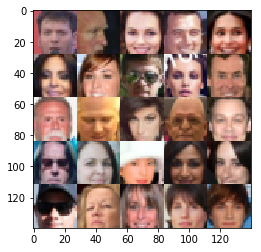

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate
    #return None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        #n, w, h, d = images.get_shape().as_list()
        alpha = 0.1
        
        #h1 = tf.layers.dense(images, w, activation=None)
        # Leaky ReLU
        #h1 = tf.maximum(alpha * h1, h1)

        #flat = tf.reshape(h1, (-1, w*h))
        #logits = tf.layers.dense(flat, 1)
        #out = tf.sigmoid(logits, name='output')
        
        
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        relu2 = tf.maximum(alpha * x2, x2)
        bn2 = tf.layers.batch_normalization(relu2, training=True)
        # 7x7x128
        
        
        x3 = tf.layers.conv2d(bn2, 256, 5, strides=2, padding='same')
        relu3 = tf.maximum(alpha * x3, x3)
        bn3 = tf.layers.batch_normalization(relu3, training=True)
        # 4x4x256
        
        flat = tf.reshape(bn3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        out = tf.sigmoid(logits)
        
        
        
        
        return out, logits

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):  
        alpha = 0.1
        
        #x1 = tf.layers.dense(z, 28*28*1)
        #x1 = tf.reshape(x1, (-1, 28, 28, 1))
        #####x1 = tf.layers.batch_normalization(x1, training=training)
        #x1 = tf.maximum(alpha * x1, x1)
    
        ####logits = tf.layers.conv2d_transpose(x1, out_channel_dim, 5, strides=2, padding='same')
        #logits = tf.layers.dense(x1, out_channel_dim, activation=None)
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #model_inputs(image_width, image_height, image_channels, z_dim):
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    #model_loss(input_real, input_z, out_channel_dim):
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #model_opt(d_loss, g_loss, learning_rate, beta1):
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                print('Step:', steps)
                
                # TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                
                if steps % 10 == 0:                    
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(steps, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 20 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                    #def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
                    
                #if steps % show_every == 0:
                #    gen_samples = sess.run(
                #                   generator(input_z, 3, reuse=True, training=False),
                #                   feed_dict={input_z: sample_z})
                #    samples.append(gen_samples)
                #    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                #    plt.show()
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Epoch 10/2... Discriminator Loss: 0.9048... Generator Loss: 0.8320
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Epoch 20/2... Discriminator Loss: 0.2842... Generator Loss: 1.7827


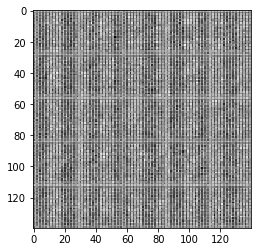

Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Epoch 30/2... Discriminator Loss: 0.1328... Generator Loss: 2.7237
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Epoch 40/2... Discriminator Loss: 0.1080... Generator Loss: 3.0191


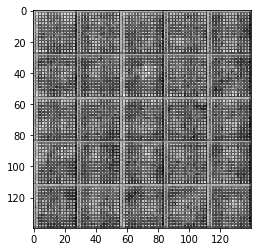

Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Epoch 50/2... Discriminator Loss: 0.0564... Generator Loss: 3.5282
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Epoch 60/2... Discriminator Loss: 0.0742... Generator Loss: 3.1508


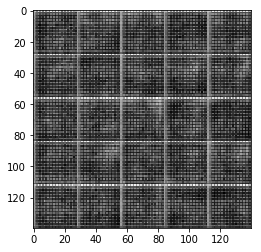

Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Epoch 70/2... Discriminator Loss: 0.0701... Generator Loss: 3.3456
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Epoch 80/2... Discriminator Loss: 0.0780... Generator Loss: 3.4065


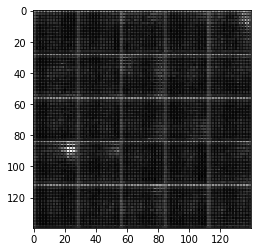

Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Epoch 90/2... Discriminator Loss: 0.2492... Generator Loss: 4.5075
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99
Step: 100
Epoch 100/2... Discriminator Loss: 0.1965... Generator Loss: 3.5469


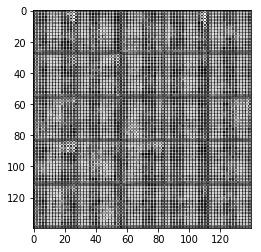

Step: 101
Step: 102
Step: 103
Step: 104
Step: 105
Step: 106
Step: 107
Step: 108
Step: 109
Step: 110
Epoch 110/2... Discriminator Loss: 0.2364... Generator Loss: 2.3987
Step: 111
Step: 112
Step: 113
Step: 114
Step: 115
Step: 116
Step: 117
Step: 118
Step: 119
Step: 120
Epoch 120/2... Discriminator Loss: 0.4622... Generator Loss: 2.0628


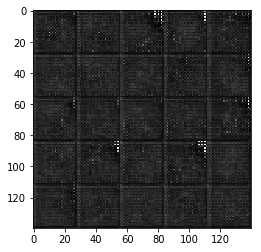

Step: 121
Step: 122
Step: 123
Step: 124
Step: 125
Step: 126
Step: 127
Step: 128
Step: 129
Step: 130
Epoch 130/2... Discriminator Loss: 0.9313... Generator Loss: 2.3391
Step: 131
Step: 132
Step: 133
Step: 134
Step: 135
Step: 136
Step: 137
Step: 138
Step: 139
Step: 140
Epoch 140/2... Discriminator Loss: 3.6253... Generator Loss: 0.1293


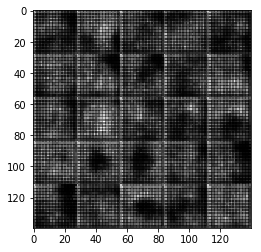

Step: 141
Step: 142
Step: 143
Step: 144
Step: 145
Step: 146
Step: 147
Step: 148
Step: 149
Step: 150
Epoch 150/2... Discriminator Loss: 1.0342... Generator Loss: 1.0977
Step: 151
Step: 152
Step: 153
Step: 154
Step: 155
Step: 156
Step: 157
Step: 158
Step: 159
Step: 160
Epoch 160/2... Discriminator Loss: 0.4721... Generator Loss: 2.4008


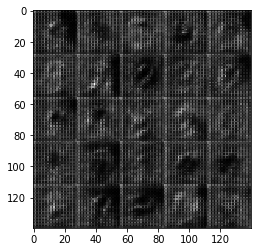

Step: 161
Step: 162
Step: 163
Step: 164
Step: 165
Step: 166
Step: 167
Step: 168
Step: 169
Step: 170
Epoch 170/2... Discriminator Loss: 0.4467... Generator Loss: 1.8333
Step: 171
Step: 172
Step: 173
Step: 174
Step: 175
Step: 176
Step: 177
Step: 178
Step: 179
Step: 180
Epoch 180/2... Discriminator Loss: 0.7705... Generator Loss: 0.8942


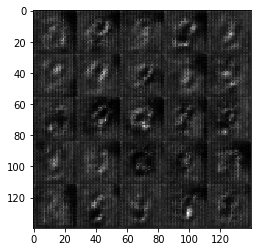

Step: 181
Step: 182
Step: 183
Step: 184
Step: 185
Step: 186
Step: 187
Step: 188
Step: 189
Step: 190
Epoch 190/2... Discriminator Loss: 1.9581... Generator Loss: 7.2120
Step: 191
Step: 192
Step: 193
Step: 194
Step: 195
Step: 196
Step: 197
Step: 198
Step: 199
Step: 200
Epoch 200/2... Discriminator Loss: 0.3417... Generator Loss: 1.8718


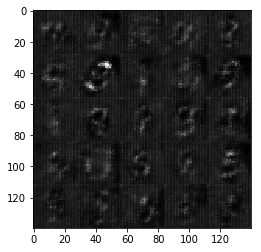

Step: 201
Step: 202
Step: 203
Step: 204
Step: 205
Step: 206
Step: 207
Step: 208
Step: 209
Step: 210
Epoch 210/2... Discriminator Loss: 0.2355... Generator Loss: 2.8740
Step: 211
Step: 212
Step: 213
Step: 214
Step: 215
Step: 216
Step: 217
Step: 218
Step: 219
Step: 220
Epoch 220/2... Discriminator Loss: 0.1740... Generator Loss: 2.6633


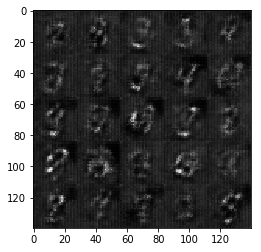

Step: 221
Step: 222
Step: 223
Step: 224
Step: 225
Step: 226
Step: 227
Step: 228
Step: 229
Step: 230
Epoch 230/2... Discriminator Loss: 0.0772... Generator Loss: 4.9431
Step: 231
Step: 232
Step: 233
Step: 234
Step: 235
Step: 236
Step: 237
Step: 238
Step: 239
Step: 240
Epoch 240/2... Discriminator Loss: 0.1795... Generator Loss: 2.7545


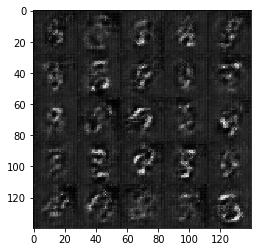

Step: 241
Step: 242
Step: 243
Step: 244
Step: 245
Step: 246
Step: 247
Step: 248
Step: 249
Step: 250
Epoch 250/2... Discriminator Loss: 0.1241... Generator Loss: 4.5186
Step: 251
Step: 252
Step: 253
Step: 254
Step: 255
Step: 256
Step: 257
Step: 258
Step: 259
Step: 260
Epoch 260/2... Discriminator Loss: 8.0341... Generator Loss: 0.0138


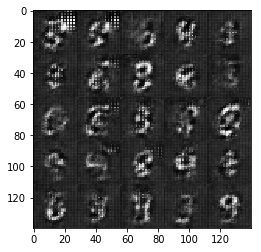

Step: 261
Step: 262
Step: 263
Step: 264
Step: 265
Step: 266
Step: 267
Step: 268
Step: 269
Step: 270
Epoch 270/2... Discriminator Loss: 0.6224... Generator Loss: 1.2140
Step: 271
Step: 272
Step: 273
Step: 274
Step: 275
Step: 276
Step: 277
Step: 278
Step: 279
Step: 280
Epoch 280/2... Discriminator Loss: 0.3659... Generator Loss: 1.7079


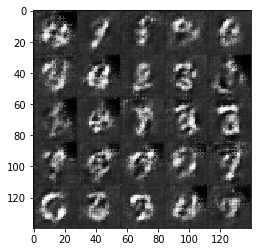

Step: 281
Step: 282
Step: 283
Step: 284
Step: 285
Step: 286
Step: 287
Step: 288
Step: 289
Step: 290
Epoch 290/2... Discriminator Loss: 0.3686... Generator Loss: 1.4654
Step: 291
Step: 292
Step: 293
Step: 294
Step: 295
Step: 296
Step: 297
Step: 298
Step: 299
Step: 300
Epoch 300/2... Discriminator Loss: 0.1003... Generator Loss: 3.6415


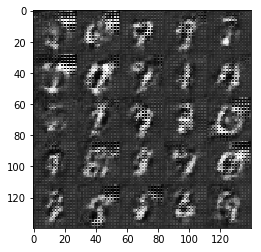

Step: 301
Step: 302
Step: 303
Step: 304
Step: 305
Step: 306
Step: 307
Step: 308
Step: 309
Step: 310
Epoch 310/2... Discriminator Loss: 0.1428... Generator Loss: 2.6368
Step: 311
Step: 312
Step: 313
Step: 314
Step: 315
Step: 316
Step: 317
Step: 318
Step: 319
Step: 320
Epoch 320/2... Discriminator Loss: 0.0200... Generator Loss: 8.5559


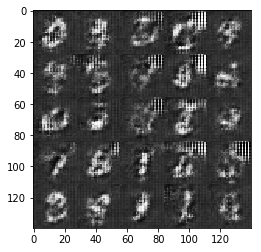

Step: 321
Step: 322
Step: 323
Step: 324
Step: 325
Step: 326
Step: 327
Step: 328
Step: 329
Step: 330
Epoch 330/2... Discriminator Loss: 0.2604... Generator Loss: 2.4799
Step: 331
Step: 332
Step: 333
Step: 334
Step: 335
Step: 336
Step: 337
Step: 338
Step: 339
Step: 340
Epoch 340/2... Discriminator Loss: 0.0836... Generator Loss: 3.2653


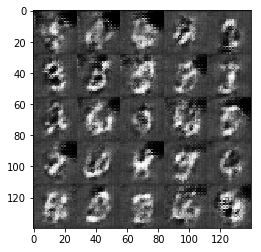

Step: 341
Step: 342
Step: 343
Step: 344
Step: 345
Step: 346
Step: 347
Step: 348
Step: 349
Step: 350
Epoch 350/2... Discriminator Loss: 0.0256... Generator Loss: 7.1630
Step: 351
Step: 352
Step: 353
Step: 354
Step: 355
Step: 356
Step: 357
Step: 358
Step: 359
Step: 360
Epoch 360/2... Discriminator Loss: 0.0898... Generator Loss: 3.6066


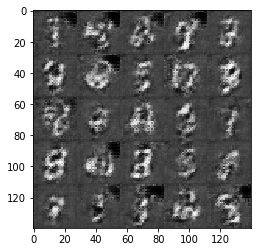

Step: 361
Step: 362
Step: 363
Step: 364
Step: 365
Step: 366
Step: 367
Step: 368
Step: 369
Step: 370
Epoch 370/2... Discriminator Loss: 0.5082... Generator Loss: 1.4131
Step: 371
Step: 372
Step: 373
Step: 374
Step: 375
Step: 376
Step: 377
Step: 378
Step: 379
Step: 380
Epoch 380/2... Discriminator Loss: 0.4709... Generator Loss: 1.3380


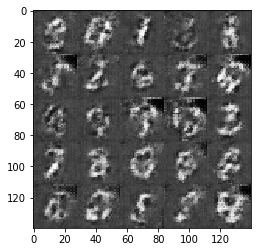

Step: 381
Step: 382
Step: 383
Step: 384
Step: 385
Step: 386
Step: 387
Step: 388
Step: 389
Step: 390
Epoch 390/2... Discriminator Loss: 0.0895... Generator Loss: 4.0981
Step: 391
Step: 392
Step: 393
Step: 394
Step: 395
Step: 396
Step: 397
Step: 398
Step: 399
Step: 400
Epoch 400/2... Discriminator Loss: 0.0913... Generator Loss: 3.3905


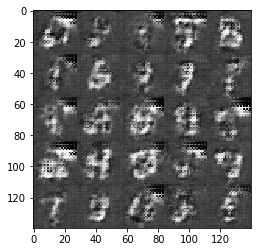

Step: 401
Step: 402
Step: 403
Step: 404
Step: 405
Step: 406
Step: 407
Step: 408
Step: 409
Step: 410
Epoch 410/2... Discriminator Loss: 0.0651... Generator Loss: 5.5050
Step: 411
Step: 412
Step: 413
Step: 414
Step: 415
Step: 416
Step: 417
Step: 418
Step: 419
Step: 420
Epoch 420/2... Discriminator Loss: 0.0782... Generator Loss: 4.4669


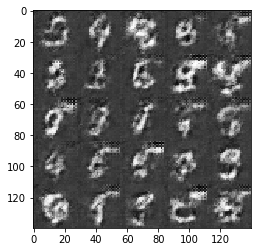

Step: 421
Step: 422
Step: 423
Step: 424
Step: 425
Step: 426
Step: 427
Step: 428
Step: 429
Step: 430
Epoch 430/2... Discriminator Loss: 0.0653... Generator Loss: 7.4931
Step: 431
Step: 432
Step: 433
Step: 434
Step: 435
Step: 436
Step: 437
Step: 438
Step: 439
Step: 440
Epoch 440/2... Discriminator Loss: 0.0354... Generator Loss: 5.5031


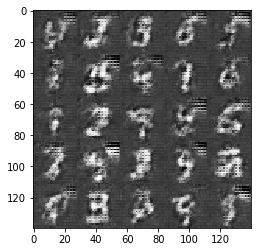

Step: 441
Step: 442
Step: 443
Step: 444
Step: 445
Step: 446
Step: 447
Step: 448
Step: 449
Step: 450
Epoch 450/2... Discriminator Loss: 0.0314... Generator Loss: 4.7400
Step: 451
Step: 452
Step: 453
Step: 454
Step: 455
Step: 456
Step: 457
Step: 458
Step: 459
Step: 460
Epoch 460/2... Discriminator Loss: 0.1768... Generator Loss: 2.6691


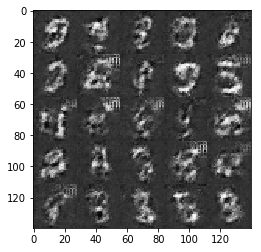

Step: 461
Step: 462
Step: 463
Step: 464
Step: 465
Step: 466
Step: 467
Step: 468
Step: 469
Step: 470
Epoch 470/2... Discriminator Loss: 0.0180... Generator Loss: 6.6682
Step: 471
Step: 472
Step: 473
Step: 474
Step: 475
Step: 476
Step: 477
Step: 478
Step: 479
Step: 480
Epoch 480/2... Discriminator Loss: 0.1406... Generator Loss: 2.7662


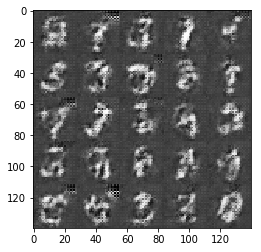

Step: 481
Step: 482
Step: 483
Step: 484
Step: 485
Step: 486
Step: 487
Step: 488
Step: 489
Step: 490
Epoch 490/2... Discriminator Loss: 0.5618... Generator Loss: 1.1815
Step: 491
Step: 492
Step: 493
Step: 494
Step: 495
Step: 496
Step: 497
Step: 498
Step: 499
Step: 500
Epoch 500/2... Discriminator Loss: 0.1256... Generator Loss: 2.8661


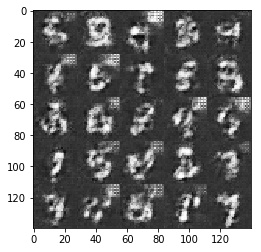

Step: 501
Step: 502
Step: 503
Step: 504
Step: 505
Step: 506
Step: 507
Step: 508
Step: 509
Step: 510
Epoch 510/2... Discriminator Loss: 0.0696... Generator Loss: 4.6165
Step: 511
Step: 512
Step: 513
Step: 514
Step: 515
Step: 516
Step: 517
Step: 518
Step: 519
Step: 520
Epoch 520/2... Discriminator Loss: 0.0571... Generator Loss: 4.4471


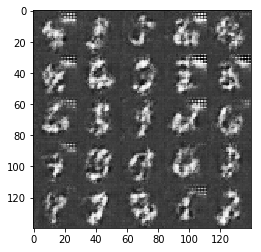

Step: 521
Step: 522
Step: 523
Step: 524
Step: 525
Step: 526
Step: 527
Step: 528
Step: 529
Step: 530
Epoch 530/2... Discriminator Loss: 0.1795... Generator Loss: 2.3062
Step: 531
Step: 532
Step: 533
Step: 534
Step: 535
Step: 536
Step: 537
Step: 538
Step: 539
Step: 540
Epoch 540/2... Discriminator Loss: 0.1088... Generator Loss: 4.3680


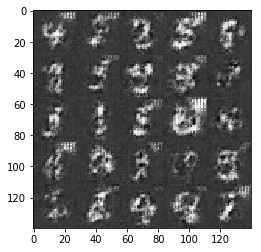

Step: 541
Step: 542
Step: 543
Step: 544
Step: 545
Step: 546
Step: 547
Step: 548
Step: 549
Step: 550
Epoch 550/2... Discriminator Loss: 0.6405... Generator Loss: 1.0086
Step: 551
Step: 552
Step: 553
Step: 554
Step: 555
Step: 556
Step: 557
Step: 558
Step: 559
Step: 560
Epoch 560/2... Discriminator Loss: 0.0350... Generator Loss: 4.2215


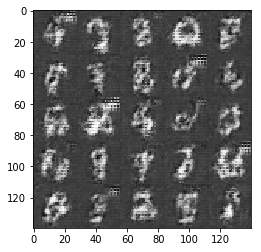

Step: 561
Step: 562
Step: 563
Step: 564
Step: 565
Step: 566
Step: 567
Step: 568
Step: 569
Step: 570
Epoch 570/2... Discriminator Loss: 0.0435... Generator Loss: 4.1315
Step: 571
Step: 572
Step: 573
Step: 574
Step: 575
Step: 576
Step: 577
Step: 578
Step: 579
Step: 580
Epoch 580/2... Discriminator Loss: 1.9565... Generator Loss: 3.2085


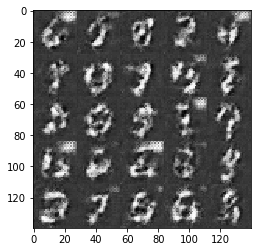

Step: 581
Step: 582
Step: 583
Step: 584
Step: 585
Step: 586
Step: 587
Step: 588
Step: 589
Step: 590
Epoch 590/2... Discriminator Loss: 0.4339... Generator Loss: 1.5692
Step: 591
Step: 592
Step: 593
Step: 594
Step: 595
Step: 596
Step: 597
Step: 598
Step: 599
Step: 600
Epoch 600/2... Discriminator Loss: 0.3453... Generator Loss: 1.8911


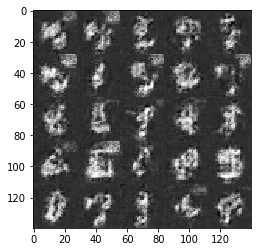

Step: 601
Step: 602
Step: 603
Step: 604
Step: 605
Step: 606
Step: 607
Step: 608
Step: 609
Step: 610
Epoch 610/2... Discriminator Loss: 0.1977... Generator Loss: 3.1170
Step: 611
Step: 612
Step: 613
Step: 614
Step: 615
Step: 616
Step: 617
Step: 618
Step: 619
Step: 620
Epoch 620/2... Discriminator Loss: 0.5267... Generator Loss: 1.1485


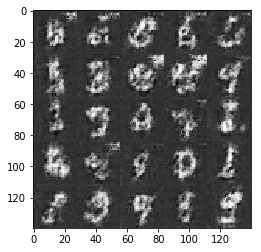

Step: 621
Step: 622
Step: 623
Step: 624
Step: 625
Step: 626
Step: 627
Step: 628
Step: 629
Step: 630
Epoch 630/2... Discriminator Loss: 0.0640... Generator Loss: 4.8701
Step: 631
Step: 632
Step: 633
Step: 634
Step: 635
Step: 636
Step: 637
Step: 638
Step: 639
Step: 640
Epoch 640/2... Discriminator Loss: 0.1268... Generator Loss: 3.1838


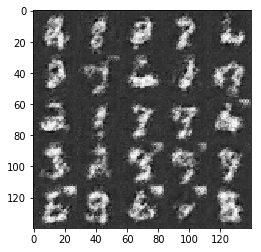

Step: 641
Step: 642
Step: 643
Step: 644
Step: 645
Step: 646
Step: 647
Step: 648
Step: 649
Step: 650
Epoch 650/2... Discriminator Loss: 0.6636... Generator Loss: 0.8436
Step: 651
Step: 652
Step: 653
Step: 654
Step: 655
Step: 656
Step: 657
Step: 658
Step: 659
Step: 660
Epoch 660/2... Discriminator Loss: 0.3170... Generator Loss: 1.6884


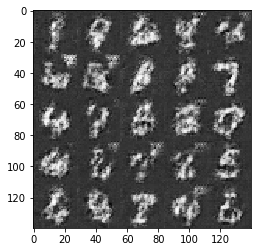

Step: 661
Step: 662
Step: 663
Step: 664
Step: 665
Step: 666
Step: 667
Step: 668
Step: 669
Step: 670
Epoch 670/2... Discriminator Loss: 0.4696... Generator Loss: 1.1419
Step: 671
Step: 672
Step: 673
Step: 674
Step: 675
Step: 676
Step: 677
Step: 678
Step: 679
Step: 680
Epoch 680/2... Discriminator Loss: 0.0184... Generator Loss: 5.4691


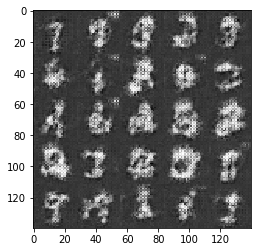

Step: 681
Step: 682
Step: 683
Step: 684
Step: 685
Step: 686
Step: 687
Step: 688
Step: 689
Step: 690
Epoch 690/2... Discriminator Loss: 0.4293... Generator Loss: 1.2527
Step: 691
Step: 692
Step: 693
Step: 694
Step: 695
Step: 696
Step: 697
Step: 698
Step: 699
Step: 700
Epoch 700/2... Discriminator Loss: 0.0223... Generator Loss: 4.6695


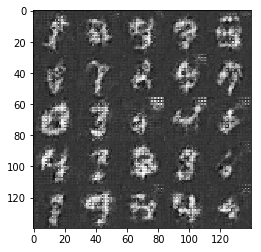

Step: 701
Step: 702
Step: 703
Step: 704
Step: 705
Step: 706
Step: 707
Step: 708
Step: 709
Step: 710
Epoch 710/2... Discriminator Loss: 0.0748... Generator Loss: 8.3648
Step: 711
Step: 712
Step: 713
Step: 714
Step: 715
Step: 716
Step: 717
Step: 718
Step: 719
Step: 720
Epoch 720/2... Discriminator Loss: 0.0968... Generator Loss: 3.3362


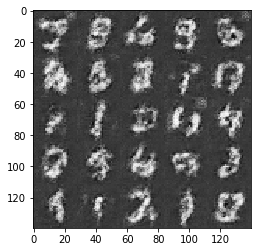

Step: 721
Step: 722
Step: 723
Step: 724
Step: 725
Step: 726
Step: 727
Step: 728
Step: 729
Step: 730
Epoch 730/2... Discriminator Loss: 0.1738... Generator Loss: 2.4582
Step: 731
Step: 732
Step: 733
Step: 734
Step: 735
Step: 736
Step: 737
Step: 738
Step: 739
Step: 740
Epoch 740/2... Discriminator Loss: 0.1811... Generator Loss: 2.1058


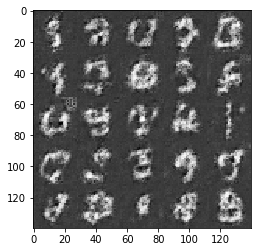

Step: 741
Step: 742
Step: 743
Step: 744
Step: 745
Step: 746
Step: 747
Step: 748
Step: 749
Step: 750
Epoch 750/2... Discriminator Loss: 0.4360... Generator Loss: 1.3113
Step: 751
Step: 752
Step: 753
Step: 754
Step: 755
Step: 756
Step: 757
Step: 758
Step: 759
Step: 760
Epoch 760/2... Discriminator Loss: 0.0346... Generator Loss: 4.4841


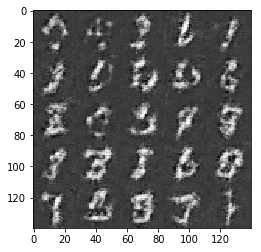

Step: 761
Step: 762
Step: 763
Step: 764
Step: 765
Step: 766
Step: 767
Step: 768
Step: 769
Step: 770
Epoch 770/2... Discriminator Loss: 0.0660... Generator Loss: 3.4357
Step: 771
Step: 772
Step: 773
Step: 774
Step: 775
Step: 776
Step: 777
Step: 778
Step: 779
Step: 780
Epoch 780/2... Discriminator Loss: 0.0481... Generator Loss: 3.6098


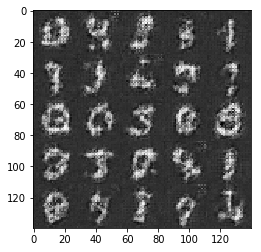

Step: 781
Step: 782
Step: 783
Step: 784
Step: 785
Step: 786
Step: 787
Step: 788
Step: 789
Step: 790
Epoch 790/2... Discriminator Loss: 0.0553... Generator Loss: 3.8900
Step: 791
Step: 792
Step: 793
Step: 794
Step: 795
Step: 796
Step: 797
Step: 798
Step: 799
Step: 800
Epoch 800/2... Discriminator Loss: 0.0335... Generator Loss: 4.0849


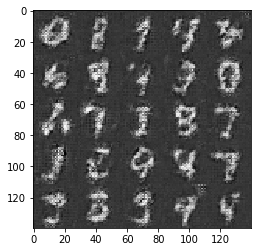

Step: 801
Step: 802
Step: 803
Step: 804
Step: 805
Step: 806
Step: 807
Step: 808
Step: 809
Step: 810
Epoch 810/2... Discriminator Loss: 0.3492... Generator Loss: 1.4398
Step: 811
Step: 812
Step: 813
Step: 814
Step: 815
Step: 816
Step: 817
Step: 818
Step: 819
Step: 820
Epoch 820/2... Discriminator Loss: 0.0476... Generator Loss: 3.5754


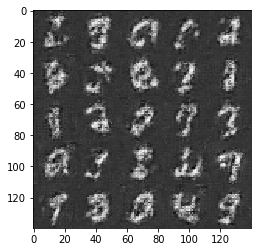

Step: 821
Step: 822
Step: 823
Step: 824
Step: 825
Step: 826
Step: 827
Step: 828
Step: 829
Step: 830
Epoch 830/2... Discriminator Loss: 0.0135... Generator Loss: 5.4538
Step: 831
Step: 832
Step: 833
Step: 834
Step: 835
Step: 836
Step: 837
Step: 838
Step: 839
Step: 840
Epoch 840/2... Discriminator Loss: 0.0502... Generator Loss: 3.6078


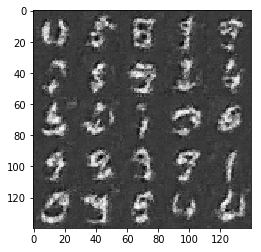

Step: 841
Step: 842
Step: 843
Step: 844
Step: 845
Step: 846
Step: 847
Step: 848
Step: 849
Step: 850
Epoch 850/2... Discriminator Loss: 0.0370... Generator Loss: 5.3090
Step: 851
Step: 852
Step: 853
Step: 854
Step: 855
Step: 856
Step: 857
Step: 858
Step: 859
Step: 860
Epoch 860/2... Discriminator Loss: 0.1705... Generator Loss: 2.0558


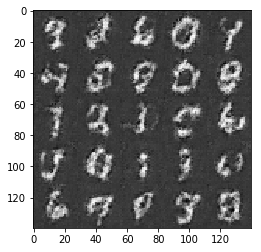

Step: 861
Step: 862
Step: 863
Step: 864
Step: 865
Step: 866
Step: 867
Step: 868
Step: 869
Step: 870
Epoch 870/2... Discriminator Loss: 0.0568... Generator Loss: 3.6101
Step: 871
Step: 872
Step: 873
Step: 874
Step: 875
Step: 876
Step: 877
Step: 878
Step: 879
Step: 880
Epoch 880/2... Discriminator Loss: 0.0602... Generator Loss: 3.8645


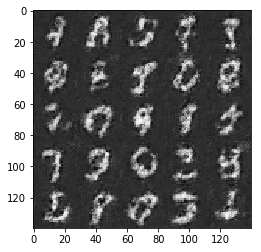

Step: 881
Step: 882
Step: 883
Step: 884
Step: 885
Step: 886
Step: 887
Step: 888
Step: 889
Step: 890
Epoch 890/2... Discriminator Loss: 0.1222... Generator Loss: 2.5363
Step: 891
Step: 892
Step: 893
Step: 894
Step: 895
Step: 896
Step: 897
Step: 898
Step: 899
Step: 900
Epoch 900/2... Discriminator Loss: 0.3883... Generator Loss: 1.9544


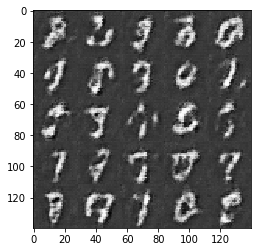

Step: 901
Step: 902
Step: 903
Step: 904
Step: 905
Step: 906
Step: 907
Step: 908
Step: 909
Step: 910
Epoch 910/2... Discriminator Loss: 0.7343... Generator Loss: 1.3510
Step: 911
Step: 912
Step: 913
Step: 914
Step: 915
Step: 916
Step: 917
Step: 918
Step: 919
Step: 920
Epoch 920/2... Discriminator Loss: 0.8876... Generator Loss: 1.7410


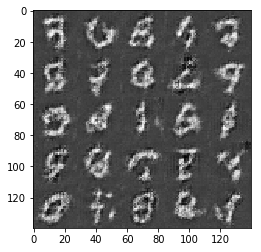

Step: 921
Step: 922
Step: 923
Step: 924
Step: 925
Step: 926
Step: 927
Step: 928
Step: 929
Step: 930
Epoch 930/2... Discriminator Loss: 2.3042... Generator Loss: 4.3763
Step: 931
Step: 932
Step: 933
Step: 934
Step: 935
Step: 936
Step: 937
Step: 938
Step: 939
Step: 940
Epoch 940/2... Discriminator Loss: 0.5097... Generator Loss: 1.2871


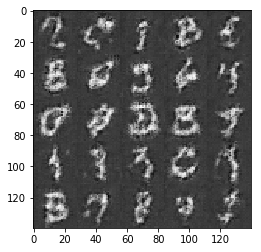

Step: 941
Step: 942
Step: 943
Step: 944
Step: 945
Step: 946
Step: 947
Step: 948
Step: 949
Step: 950
Epoch 950/2... Discriminator Loss: 0.7877... Generator Loss: 0.7575
Step: 951
Step: 952
Step: 953
Step: 954
Step: 955
Step: 956
Step: 957
Step: 958
Step: 959
Step: 960
Epoch 960/2... Discriminator Loss: 0.3019... Generator Loss: 1.8078


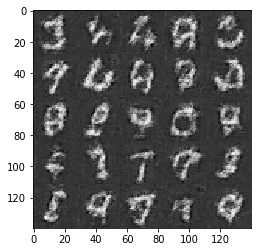

Step: 961
Step: 962
Step: 963
Step: 964
Step: 965
Step: 966
Step: 967
Step: 968
Step: 969
Step: 970
Epoch 970/2... Discriminator Loss: 0.1756... Generator Loss: 2.4460
Step: 971
Step: 972
Step: 973
Step: 974
Step: 975
Step: 976
Step: 977
Step: 978
Step: 979
Step: 980
Epoch 980/2... Discriminator Loss: 0.3163... Generator Loss: 1.5639


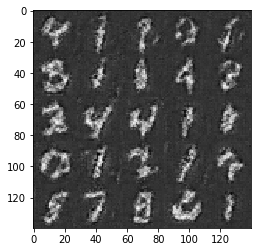

Step: 981
Step: 982
Step: 983
Step: 984
Step: 985
Step: 986
Step: 987
Step: 988
Step: 989
Step: 990
Epoch 990/2... Discriminator Loss: 0.7586... Generator Loss: 0.7950
Step: 991
Step: 992
Step: 993
Step: 994
Step: 995
Step: 996
Step: 997
Step: 998
Step: 999
Step: 1000
Epoch 1000/2... Discriminator Loss: 0.0781... Generator Loss: 3.2697


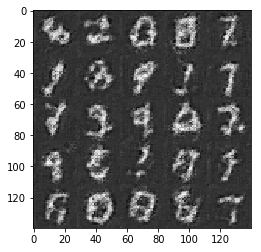

Step: 1001
Step: 1002
Step: 1003
Step: 1004
Step: 1005
Step: 1006
Step: 1007
Step: 1008
Step: 1009
Step: 1010
Epoch 1010/2... Discriminator Loss: 0.0640... Generator Loss: 3.5398
Step: 1011
Step: 1012
Step: 1013
Step: 1014
Step: 1015
Step: 1016
Step: 1017
Step: 1018
Step: 1019
Step: 1020
Epoch 1020/2... Discriminator Loss: 0.0606... Generator Loss: 3.9619


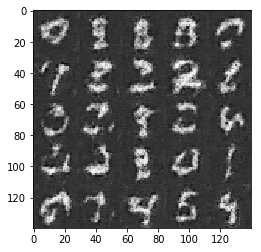

Step: 1021
Step: 1022
Step: 1023
Step: 1024
Step: 1025
Step: 1026
Step: 1027
Step: 1028
Step: 1029
Step: 1030
Epoch 1030/2... Discriminator Loss: 0.0388... Generator Loss: 4.6396
Step: 1031
Step: 1032
Step: 1033
Step: 1034
Step: 1035
Step: 1036
Step: 1037
Step: 1038
Step: 1039
Step: 1040
Epoch 1040/2... Discriminator Loss: 0.1116... Generator Loss: 2.6133


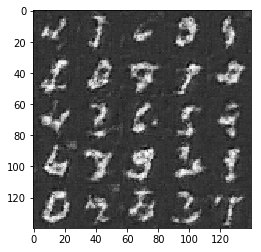

Step: 1041
Step: 1042
Step: 1043
Step: 1044
Step: 1045
Step: 1046
Step: 1047
Step: 1048
Step: 1049
Step: 1050
Epoch 1050/2... Discriminator Loss: 0.0625... Generator Loss: 3.4061
Step: 1051
Step: 1052
Step: 1053
Step: 1054
Step: 1055
Step: 1056
Step: 1057
Step: 1058
Step: 1059
Step: 1060
Epoch 1060/2... Discriminator Loss: 0.1935... Generator Loss: 2.0524


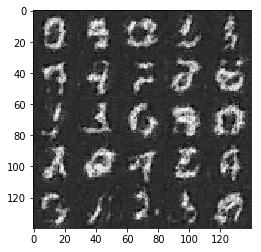

Step: 1061
Step: 1062
Step: 1063
Step: 1064
Step: 1065
Step: 1066
Step: 1067
Step: 1068
Step: 1069
Step: 1070
Epoch 1070/2... Discriminator Loss: 0.0864... Generator Loss: 3.0983
Step: 1071
Step: 1072
Step: 1073
Step: 1074
Step: 1075
Step: 1076
Step: 1077
Step: 1078
Step: 1079
Step: 1080
Epoch 1080/2... Discriminator Loss: 0.1350... Generator Loss: 2.6086


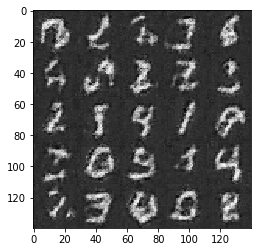

Step: 1081
Step: 1082
Step: 1083
Step: 1084
Step: 1085
Step: 1086
Step: 1087
Step: 1088
Step: 1089


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.